In [1]:
import numpy as np
import pandas as pd
from scipy.stats import poisson, norm
import pymc as pm
import arviz as az

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

In [2]:
data = pd.read_csv("datasets/nestsize.csv")

Text(0.5, 0.98, 'Nest count')

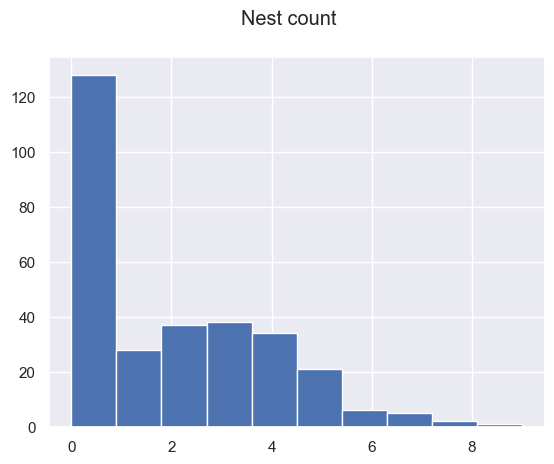

In [3]:
fig, ax = plt.subplots()
ax.hist(data["count"])
fig.suptitle("Nest count")

In [6]:
y = w * norm.pdf(x=np.linspace(-3,9, 100), loc=mu1, scale=sigma) + (1-w) * norm.pdf(x=np.linspace(-3,9, 100), loc=mu2, scale=sigma)

In [7]:
# x = data["count"].to_numpy()
x = np.concatenate([x1,x2])

## EM Alogirithm
mixture of two normals

1.7184736909114583e-06


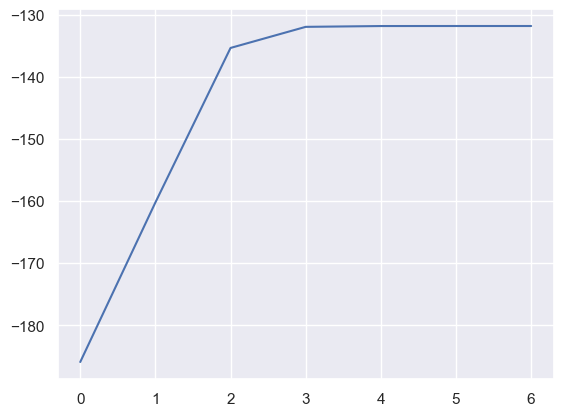

In [8]:
K = 2
w_0 = 0.5

w = w_0
means_0 = np.array([0.5,2.5])
sigma_0 = np.array([1])

mu = means_0
sigma = sigma_0

QQ = []
QQ_last = -1e5

eps = 1e-5

for i in range(100000):
    # E step
    v = np.zeros((len(x), K))

    v[:,0] = np.log(w) + norm.logpdf(x, loc=mu[0], scale=sigma)
    # v[:,1] = np.log(1-w) + poisson.logpmf(x, mu=mu[1])
    v[:,1] = np.log(1-w) + norm.logpdf(x, loc=mu[1], scale=sigma)


    # for i in range(len(x)):
    #     max_v = np.max(v[i,:])
    #     v[i,:] = np.exp(v[i,:] - max_v) / np.sum(np.exp(v[i,:] - max_v))
    v = np.exp(v - np.max(v, axis=1).reshape(-1,1)) / np.sum(np.exp(v - np.max(v, axis=1).reshape(-1,1)), axis=1).reshape(-1,1)
    # M step
    w = np.mean(v[:,0])

    # mu[0] = (mu[0] + np.dot(v[:,0], x)) / np.sum(v[:,0])
    # mu = np.zeros(2)
    # mu[0] = (np.dot(v[:,0], x)) / np.sum(v[:,0])
    # mu[1] = (np.dot(v[:,1], x)) / np.sum(v[:,1])
    # for k in range(K):
    #     for i in range(len(x)):
    #         mu[k] = mu[k] + v[i,k] * x[i]
    #     mu[k] = mu[k] / np.sum(v[:,k])
    mu = np.sum(v * x.reshape(-1,1), axis=0) / np.sum(v, axis=0)
    sigma = 0

    

    # sigma = sigma + np.dot(v[:,0],np.power(x - mu[0], 2) )
    # sigma = sigma + np.dot(v[:,1],np.power(x - mu[1], 2) )
    # sigma = np.sqrt(sigma)
    for i in range(len(x)):
        for k in range(K):
            sigma = sigma + v[i, k] * np.power(x[i] - mu[k], 2)
    
    sigma = np.sqrt(sigma / np.sum(v))

    
    # Convergence Check
    QQ_current = 0
    QQ_current += np.dot(v[:,0] , (np.log(w) + norm.logpdf(x, loc=mu[0], scale=sigma)))
    QQ_current += np.dot(v[:,1] , (np.log(1-w) + norm.logpdf(x, loc=mu[1], scale=sigma)))

    epsilon = np.abs(QQ_current - QQ_last) / np.abs(QQ_current)

    QQ_last = QQ_current
    QQ.append(QQ_last)

    if epsilon < eps:
        print(epsilon)
        break

plt.plot(QQ) 

In [9]:
w, mu, sigma

(0.2993784023898488, array([1.06509074, 4.02502024]), 0.4912555568166106)

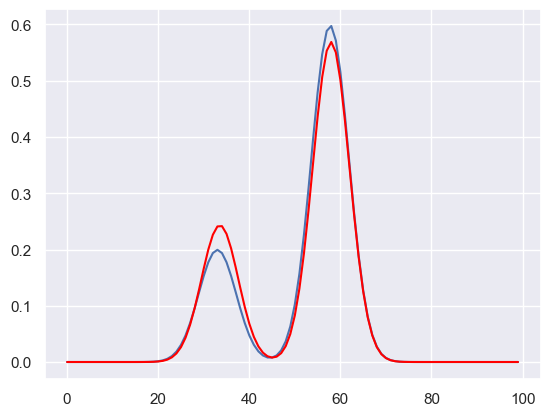

In [10]:
y_pred = w * norm.pdf(x=np.linspace(-3,9, 100), loc=mu[0], scale=sigma) + (1-w) * norm.pdf(x=np.linspace(-3,9, 100), loc=mu[1], scale=sigma)
plt.plot(y)
plt.plot(y_pred, color="red")

## EM for ZIPF

In [11]:
data = pd.read_csv("datasets/nestsize.csv")

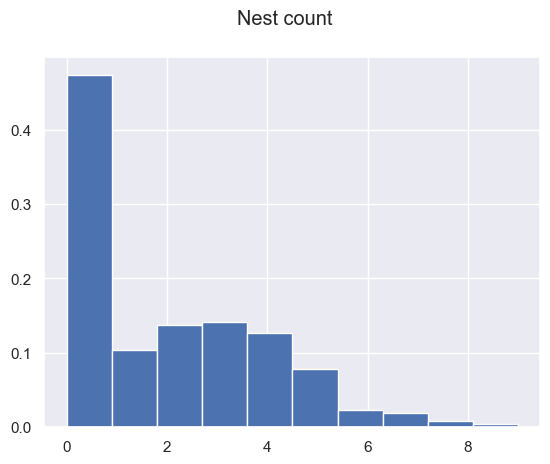

In [53]:
fig, ax = plt.subplots()
ax.hist(data["count"], density=True)
fig.suptitle("Nest count")

x = data["count"].to_numpy()

$$ p(Z) =   \begin{cases} 
                \omega + (1-\omega) Poisson(\lambda)  & x = 0 \\
                (1-\omega) Poisson(\lambda) & x > 0
            \end{cases}
$$

Coursera Answer

#### E-step
$$ v_{i,1} \propto  \begin{cases}
                        w & x_i = 0 \\
                        0 & x_i > 0
                    \end{cases} $$

$$ v_{i,2} \propto  \begin{cases}
                        (1-w) \frac {\lambda ^ x_i e^{-\lambda} } {x_i !} & x_i = 0 \\
                        1 & x_i > 0
                    \end{cases} $$



#### M Step
$$
    Q(w, \lambda | {\hat w}^{(t)},  {\hat \lambda}^{(t)} ) = \sum Q_i(w, \lambda | {\hat w}^{(t)},  {\hat \lambda}^{(t)}, x_i) \\
    
    Q_i(w, \lambda | {\hat w}^{(t)},  {\hat \lambda}^{(t)}, x_i) = 
            \begin{cases}
                v_{i,1} \log w + v_{i,2}[\log (1-w) - \lambda + x_i \log \lambda - \log x! ] & x_i = 0 \\
                v_{i,2}[\log (1-w) - \lambda + x_i \log \lambda - \log x! ] & x_i > 0 \\
            \end{cases} 
$$
computing derivatives gives

$$
\hat {w} ^{(t+1)} = \frac {1} {n} \sum v_{i,1} $$
$$
 \hat {\lambda} ^{(t)} = \frac {\sum x_i} {\sum v_{i,2}}
$$

R-code:

    // while convergence is not met
    {
        // E-step
        gamma = log(pi1 / (1-pi1))
        z1 = array(0, dim=n)

        for (i in 1:n) {
            if (x[i] == 0) {
                z1[i] = exp(gamma) / (exp(gamma) + dpois(0, lambda))
            }
        }

        // M-step
        lambda = sum(x %*% (1-z1)) / sum(1-z1)
        gamma = log(mean(z1)) - log(1 - mean(z1))

        QQn = 0
        for {i in 1:n
            QQn = QQn + z1[i]*gamma - log(1+exp(gamma)) + (1-z1[i])*dpois(x[i], lambda, log=True)
        }
        
        // Check Convergence

        pi1 = exp(gamma) / (1 + exp(gamma))

    }

2.7795939586862296e-06
w: 0.40012911481879787
lambda: 3.0728834802117797


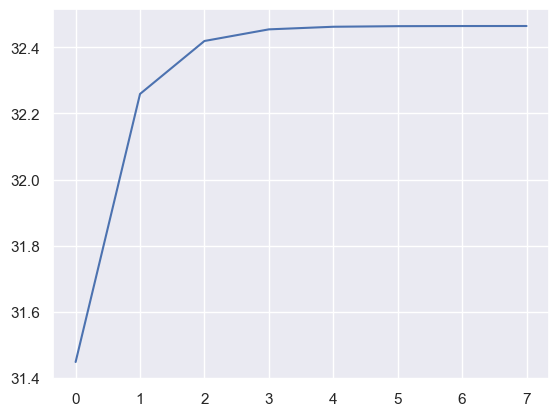

In [134]:
K = 2
w_0 = 0.5

w = w_0
means_0 = 10
# sigma_0 = np.array([1])

mu = means_0
# sigma = sigma_0

QQ = []
QQ_last = -1e5

eps = 1e-5

mu_ = []
w_ = []

for i in range(1000):
    # E step
    p_Z = np.zeros((len(x), K))

    z = np.where(x == 0)
    p_Z[z,0] = w  + w * poisson.pmf(x[z], mu=mu)
    p_Z[z,1] = (1 - w) * poisson.pmf(x[z], mu=mu)
    
    z = np.where(x > 0)
    p_Z[z,0] = 0
    p_Z[z,1] = (1 - w) * poisson.pmf(x[z], mu=mu)

    p_Z = p_Z / np.sum(p_Z, axis=1).reshape(-1,1)


    # M step
    w = np.mean(p_Z[:,0])

    mu = np.sum(p_Z[:,1] * x) / np.sum(p_Z[:,1])

    mu_.append(mu)
    w_.append(w)

    # # Convergence Check
    
    QQ_current = np.sum(np.log(w + w * poisson.pmf(x, mu=mu) + (1-w) + (1-w) * poisson.pmf(x, mu=mu)))

    epsilon = np.abs(QQ_current - QQ_last) / np.abs(QQ_current)

    QQ_last = QQ_current
    QQ.append(QQ_last)

    if epsilon < eps:
        print(epsilon)
        break


plt.plot(QQ)
print(f"w: {w}")
print(f"lambda: {mu}")

In [132]:
y_pred = (1-w) * poisson.pmf(k=np.arange(0,10), mu=mu) 
y_pred[0] = y_pred[0] + w
y_pred = y_pred

(array([0.42666667, 0.09333333, 0.12333333, 0.12666667, 0.11333333,
        0.07      , 0.02      , 0.01666667, 0.01      ]),
 array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.]),
 <BarContainer object of 9 artists>)

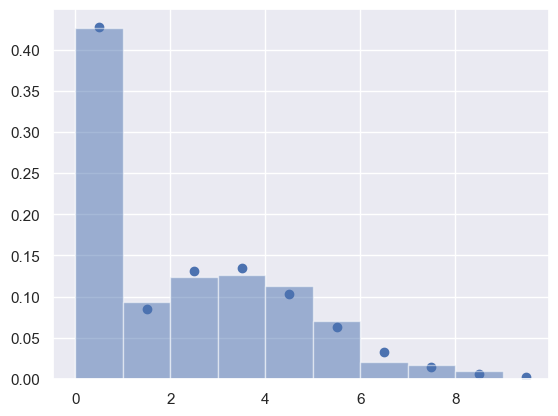

In [133]:
fig, ax = plt.subplots()

ax.scatter(x=np.arange(0,10) + 0.5, y=y_pred)
ax.hist(x=x, alpha=0.5, bins=np.arange(0,10), density=True)

In [4]:
with pm.Model() as mixture_model:
    # omega_prior = pm.Beta("omega_prior", 2, 2)
    
    omega = pm.Dirichlet("omega", [2])

    # label = pm.Binomial("label", n=1, p=omega)
    label = pm.Categorical("label", [omega, 1-omega])

In [57]:
with mixture_model:
    prior_predictive = pm.sample_prior_predictive()

Sampling: [label, omega]


ValueError: x must have 2 or fewer dimensions

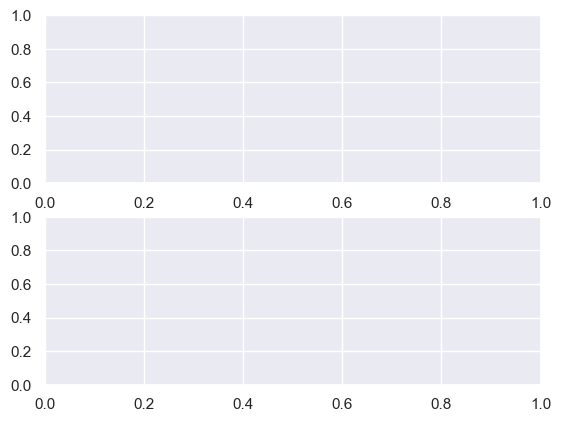

In [55]:
fig, ax = plt.subplots(2, 1)
# pm.plot_dist(az.extract(prior_predictive, "prior", "omega").to_array(), ax=ax[0])
ax[1].hist(az.extract(prior_predictive, "prior", "label").to_array())

In [58]:
prior_predictive.prior.label

<xarray.DataArray 'label' (chain: 1, draw: 500, label_dim_0: 2)>
array([[[0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
...
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1],
        [0, 1]]])
Coordinates:
  * chain        (chain) int64 0
  * draw         (draw) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * label_dim_0  (label_dim_0) int64 0 1

In [47]:
az.extract(prior_predictive, "prior", "label").to_array()

<xarray.DataArray (variable: 2, label_dim_0: 2, sample: 500, omega_dim_0: 2)>
array([[[[1.        , 1.        ],
         [1.        , 1.        ],
         [1.        , 1.        ],
         ...,
         [0.        , 0.        ],
         [1.        , 1.        ],
         [1.        , 1.        ]],

        [[0.        , 0.        ],
         [0.        , 0.        ],
         [1.        , 1.        ],
         ...,
         [1.        , 1.        ],
         [1.        , 1.        ],
         [1.        , 1.        ]]],


       [[[0.85254871, 0.14745129],
         [0.9043347 , 0.0956653 ],
         [0.24355856, 0.75644144],
         ...,
         [0.38392877, 0.61607123],
         [0.59640968, 0.40359032],
         [0.62571643, 0.37428357]],

        [[0.85254871, 0.14745129],
         [0.9043347 , 0.0956653 ],
         [0.24355856, 0.75644144],
         ...,
         [0.38392877, 0.61607123],
         [0.59640968, 0.40359032],
         [0.62571643, 0.37428357]]]])
Coordinates:
  * label_dim_0  (label_dim_0) int64 0 1
  * omega_dim_0  (omega_dim_0) int64 0 1
  * sample       (sample) object MultiIndex
  * chain        (sample) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
  * draw         (sample) int64 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499
  * variable     (variable) object 'label' 'omega'
Attributes:
    created_at:                 2023-04-21T23:50:03.284842
    arviz_version:              0.14.0
    inference_library:          pymc
    inference_library_version:  5.2.0

In [17]:
pm.plot_dist()

AttributeError: 'Dataset' object has no attribute 'to_numpy'